In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path
import time
import matplotlib.pyplot as plt

from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    balanced_accuracy_score,
    ConfusionMatrixDisplay,
    f1_score,
    accuracy_score
)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [2]:
processed_dir = Path("../data/processed")
in_path = processed_dir / "windows_identity_df.csv"

df = pd.read_csv(in_path)
print("Loaded dataset:", df.shape)
df.head()

Loaded dataset: (78914, 23)


,acc_max,acc_mean,acc_std,acc_range,acc_energy,gyro_max,gyro_mean,gyro_std,gyro_range,gyro_energy,...,activity_code,age,height_cm,weight_kg,gender,pid,synthetic_name,synthetic_address,synthetic_phone,synthetic_patient_id
0,1.505301,1.021371,0.161249,0.748475,213.839935,61.501696,36.275651,8.270789,49.125849,276865.758002,...,D01,26,165,53.0,F,8b39978f3bf493e0,Allison Hill,"893 Nathaniel Estates Apt. 957, North Sarahpor...",631-335-1823x374,Xx-02681177
1,1.686817,1.094025,0.183646,0.891159,246.123306,77.213308,43.917027,14.533872,61.152478,427987.746894,...,D01,26,165,53.0,F,8b39978f3bf493e0,Allison Hill,"893 Nathaniel Estates Apt. 957, North Sarahpor...",631-335-1823x374,Xx-02681177
2,1.598864,1.042618,0.176089,0.814388,223.612030,61.102289,39.110576,11.105643,46.904561,330594.491214,...,D01,26,165,53.0,F,8b39978f3bf493e0,Allison Hill,"893 Nathaniel Estates Apt. 957, North Sarahpor...",631-335-1823x374,Xx-02681177
3,1.388703,1.040773,0.144043,0.621426,220.791382,77.614763,31.088233,13.225029,70.586703,228275.924921,...,D01,26,165,53.0,F,8b39978f3bf493e0,Allison Hill,"893 Nathaniel Estates Apt. 957, North Sarahpor...",631-335-1823x374,Xx-02681177
4,1.441374,1.059405,0.145564,0.639070,228.705505,67.388147,33.309296,12.482396,57.557886,253063.883632,...,D01,26,165,53.0,F,8b39978f3bf493e0,Allison Hill,"893 Nathaniel Estates Apt. 957, North Sarahpor...",631-335-1823x374,Xx-02681177


In [3]:
FEATURE_COLS = [
    "acc_max", "acc_mean", "acc_std", "acc_range", "acc_energy",
    "gyro_max", "gyro_mean", "gyro_std", "gyro_range", "gyro_energy",
]

LABEL_COL = "label"
GROUP_COL = "subject_id"

X = df[FEATURE_COLS]
y = df["label"]
groups = df["subject_id"]  # split por sujeito

EPSILONS = [2.0, 1.0, 0.5]

print("X:", X.shape)
print("y distribution:", y.value_counts().to_dict())
print("Subjects:", groups.nunique())


X: (78914, 10)
y distribution: {0: 52066, 1: 26848}
Subjects: 38


In [4]:
gss = GroupShuffleSplit(
    n_splits=1,
    test_size=0.2,
    random_state=42
)

train_idx, test_idx = next(gss.split(X, y, groups))

X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

print("Train size:", X_train.shape)
print("Test size:", X_test.shape)
print("Train subjects:", groups.iloc[train_idx].nunique())
print("Test subjects:", groups.iloc[test_idx].nunique())

Train size: (65242, 10)
Test size: (13672, 10)
Train subjects: 30
Test subjects: 8


In [5]:
logreg_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(
        max_iter=1000,
        class_weight="balanced",
        random_state=42
    ))
])

In [6]:
t0 = time.perf_counter()
logreg_pipeline.fit(X_train, y_train)
train_time_lr = time.perf_counter() - t0

In [7]:
t0 = time.perf_counter()
y_pred_lr = logreg_pipeline.predict(X_test)
test_time_lr = time.perf_counter() - t0

In [8]:
print("=== Logistic Regression ===")
print("Train time (s):", round(train_time_lr, 4))
print("Test time (s):", round(test_time_lr, 4))
print("Balanced accuracy:", balanced_accuracy_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr, target_names=["ADL","Fall"]))
cm_lg = confusion_matrix(y_test, y_pred_lr)


=== Logistic Regression ===
Train time (s): 0.148
Test time (s): 0.002
Balanced accuracy: 0.6454827547654225
              precision    recall  f1-score   support

         ADL       0.88      0.51      0.65     10313
        Fall       0.34      0.78      0.48      3359

    accuracy                           0.58     13672
   macro avg       0.61      0.65      0.56     13672
weighted avg       0.75      0.58      0.60     13672



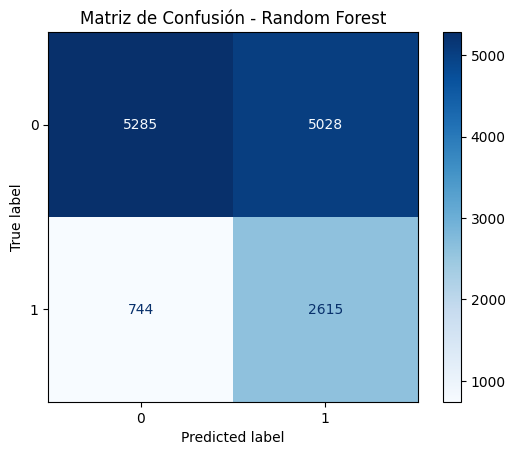

In [9]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm_lg)
disp.plot(cmap="Blues")

plt.title("Matriz de Confusión - Random Forest")
plt.show()

In [10]:
rf = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    n_jobs=-1,
    class_weight="balanced"
)

In [11]:
t0 = time.perf_counter()
rf.fit(X_train, y_train)
train_time_rf = time.perf_counter() - t0

In [12]:
t0 = time.perf_counter()
y_pred_rf = rf.predict(X_test)
test_time_rf = time.perf_counter() - t0

In [13]:
print("=== Random Forest ===")
print("Train time (s):", round(train_time_rf, 4))
print("Test time (s):", round(test_time_rf, 4))
print("Balanced accuracy:", balanced_accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf, target_names=["ADL","Fall"]))
cm_rf = confusion_matrix(y_test, y_pred_rf)

=== Random Forest ===
Train time (s): 7.4937
Test time (s): 0.0738
Balanced accuracy: 0.645075293939757
              precision    recall  f1-score   support

         ADL       0.83      0.83      0.83     10313
        Fall       0.47      0.46      0.46      3359

    accuracy                           0.74     13672
   macro avg       0.65      0.65      0.65     13672
weighted avg       0.74      0.74      0.74     13672



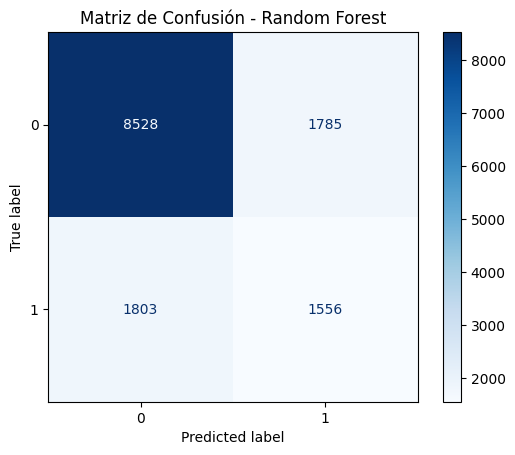

In [14]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm_rf)
disp.plot(cmap="Blues")

plt.title("Matriz de Confusión - Random Forest")
plt.show()

In [15]:
summary = pd.DataFrame([
    {
        "model": "Logistic Regression",
        "train_time_s": train_time_lr,
        "test_time_s": test_time_lr,
        "balanced_accuracy": balanced_accuracy_score(y_test, y_pred_lr),
    },
    {
        "model": "Random Forest",
        "train_time_s": train_time_rf,
        "test_time_s": test_time_rf,
        "balanced_accuracy": balanced_accuracy_score(y_test, y_pred_rf),
    }
])

summary

,model,train_time_s,test_time_s,balanced_accuracy
0,Logistic Regression,0.147974,0.002007,0.645483
1,Random Forest,7.493651,0.073796,0.645075


In [16]:
def eval_models(X_train, y_train, X_test, y_test):
    models = {
        "LogReg": Pipeline([
            ("scaler", StandardScaler()),
            ("clf", LogisticRegression(max_iter=2000))
        ]),
        "RandomForest": RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1)
    }

    rows = []
    for name, model in models.items():
        model.fit(X_train, y_train)
        pred = model.predict(X_test)
        rows.append({
            "model": name,
            "balanced_accuracy": balanced_accuracy_score(y_test, pred),
            "f1_macro": f1_score(y_test, pred, average="macro")
        })
    return pd.DataFrame(rows)

In [17]:
res_all = []

res_b = eval_models(
    df[FEATURE_COLS].iloc[train_idx], df[LABEL_COL].iloc[train_idx],
    df[FEATURE_COLS].iloc[test_idx],  df[LABEL_COL].iloc[test_idx]
)
res_b["setting"] = "baseline"
res_all.append(res_b)


In [18]:
for eps in EPSILONS:
    df_before = pd.read_csv(processed_dir / f"windows_identity_dp_before_eps{eps}.csv")
    df_after  = pd.read_csv(processed_dir / f"windows_identity_dp_after_eps{eps}.csv")

    # DP BEFORE
    res_before = eval_models(
        df_before[FEATURE_COLS].iloc[train_idx], df_before[LABEL_COL].iloc[train_idx],
        df_before[FEATURE_COLS].iloc[test_idx],  df_before[LABEL_COL].iloc[test_idx]
    )
    res_before["setting"] = f"dp_before_eps={eps}"
    res_all.append(res_before)

    # DP AFTER
    res_after = eval_models(
        df_after[FEATURE_COLS].iloc[train_idx], df_after[LABEL_COL].iloc[train_idx],
        df_after[FEATURE_COLS].iloc[test_idx],  df_after[LABEL_COL].iloc[test_idx]
    )
    res_after["setting"] = f"dp_after_eps={eps}"
    res_all.append(res_after)

results = pd.concat(res_all, ignore_index=True)
results


,model,balanced_accuracy,f1_macro,setting
0,LogReg,0.525267,0.490642,baseline
1,RandomForest,0.647590,0.645283,baseline
2,LogReg,0.524409,0.503964,dp_before_eps=2.0
3,RandomForest,0.532980,0.530510,dp_before_eps=2.0
4,LogReg,0.500000,0.429977,dp_after_eps=2.0
5,RandomForest,0.502614,0.457385,dp_after_eps=2.0
6,LogReg,0.507491,0.459676,dp_before_eps=1.0
7,RandomForest,0.513936,0.494586,dp_before_eps=1.0
8,LogReg,0.500000,0.429977,dp_after_eps=1.0
9,RandomForest,0.500964,0.439876,dp_after_eps=1.0


In [19]:
pivot_acc = results.pivot(index="model", columns="setting", values="balanced_accuracy")
pivot_acc

setting,baseline,dp_after_eps=0.5,dp_after_eps=1.0,dp_after_eps=2.0,dp_before_eps=0.5,dp_before_eps=1.0,dp_before_eps=2.0
model,,,,,,,
LogReg,0.525267,0.500000,0.500000,0.500000,0.500204,0.507491,0.524409
RandomForest,0.647590,0.499901,0.500964,0.502614,0.504838,0.513936,0.532980


In [25]:
def load_before(eps):
    return pd.read_csv(processed_dir / f"windows_identity_dp_before_eps{eps}.csv")

def load_after(eps):
    return pd.read_csv(processed_dir / f"windows_identity_dp_after_eps{eps}.csv")

In [26]:
classes = sorted(df[LABEL_COL].unique())
classes

[np.int64(0), np.int64(1)]

In [27]:
models = {
    "LogReg": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(max_iter=2000))
    ]),
    "RandomForest": RandomForestClassifier(
        n_estimators=300, random_state=42, n_jobs=-1
    )
}


In [28]:
def full_model_report(model, X_train, y_train, X_test, y_test, labels_order):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    rep = classification_report(
        y_test, y_pred,
        labels=labels_order,
        output_dict=True,
        zero_division=0
    )

    cm = confusion_matrix(y_test, y_pred, labels=labels_order)

    summary = {
        "accuracy": accuracy_score(y_test, y_pred),
        "balanced_accuracy": balanced_accuracy_score(y_test, y_pred),
        "f1_macro": f1_score(y_test, y_pred, average="macro"),
        "f1_weighted": f1_score(y_test, y_pred, average="weighted"),
    }

    return rep, cm, summary


In [30]:
all_reports = []          
all_class_reports = []    
all_conf_mats = {}        

def run_setting(df, setting_name):
    X_train = df[FEATURE_COLS].iloc[train_idx]
    y_train = df[LABEL_COL].iloc[train_idx]
    X_test  = df[FEATURE_COLS].iloc[test_idx]
    y_test  = df[LABEL_COL].iloc[test_idx]

    for model_name, model in models.items():
        rep, cm, summary = full_model_report(model, X_train, y_train, X_test, y_test, classes)

        # summary
        all_reports.append({
            "setting": setting_name,
            "model": model_name,
            **summary
        })

        # guardar confusion matrix
        all_conf_mats[(setting_name, model_name)] = cm

        # classification report (por classe) -> tabela
        rep_df = pd.DataFrame(rep).T
        rep_df["setting"] = setting_name
        rep_df["model"] = model_name
        rep_df["row"] = rep_df.index
        all_class_reports.append(rep_df.reset_index(drop=True))

        # print bonito
        print("\n" + "="*90)
        print(f"SETTING: {setting_name} | MODEL: {model_name}")
        print("-"*90)
        print("Summary:", summary)
        print("\nClassification report:")
        print(pd.DataFrame(rep).T)
        print("\nConfusion matrix (rows=true, cols=pred) | labels:", classes)
        print(cm)

# Baseline
run_setting(df, "baseline")

# DP before e DP after
for eps in EPSILONS:
    df_b = load_before(eps)
    df_a = load_after(eps)

    run_setting(df_b, f"dp_before_eps={eps}")
    run_setting(df_a, f"dp_after_eps={eps}")



SETTING: baseline | MODEL: LogReg
------------------------------------------------------------------------------------------
Summary: {'accuracy': 0.7576067875950848, 'balanced_accuracy': 0.5252671177785796, 'f1_macro': 0.49064206585981524, 'f1_weighted': 0.6782024492652572}

Classification report:
              precision    recall  f1-score       support
0              0.763974  0.982061  0.859398  10313.000000
1              0.554217  0.068473  0.121887   3359.000000
accuracy       0.757607  0.757607  0.757607      0.757607
macro avg      0.659095  0.525267  0.490642  13672.000000
weighted avg   0.712440  0.757607  0.678202  13672.000000

Confusion matrix (rows=true, cols=pred) | labels: [np.int64(0), np.int64(1)]
[[10128   185]
 [ 3129   230]]

SETTING: baseline | MODEL: RandomForest
------------------------------------------------------------------------------------------
Summary: {'accuracy': 0.7330310122878877, 'balanced_accuracy': 0.6475898020998998, 'f1_macro': 0.6452834184264

In [31]:
summary_df = pd.DataFrame(all_reports)
summary_df.sort_values(["model", "setting"])

,setting,model,accuracy,balanced_accuracy,f1_macro,f1_weighted
0,baseline,LogReg,0.757607,0.525267,0.490642,0.678202
12,dp_after_eps=0.5,LogReg,0.754315,0.500000,0.429977,0.648677
8,dp_after_eps=1.0,LogReg,0.754315,0.500000,0.429977,0.648677
4,dp_after_eps=2.0,LogReg,0.754315,0.500000,0.429977,0.648677
10,dp_before_eps=0.5,LogReg,0.754169,0.500204,0.430803,0.649016
6,dp_before_eps=1.0,LogReg,0.747294,0.507491,0.459676,0.660187
2,dp_before_eps=2.0,LogReg,0.738444,0.524409,0.503964,0.677429
1,baseline,RandomForest,0.733031,0.647590,0.645283,0.735018
13,dp_after_eps=0.5,RandomForest,0.749927,0.499901,0.436437,0.650226
9,dp_after_eps=1.0,RandomForest,0.749561,0.500964,0.439876,0.651715


In [32]:
class_report_df = pd.concat(all_class_reports, ignore_index=True)
class_report_df.head()

,precision,recall,f1-score,support,setting,model,row
0,0.763974,0.982061,0.859398,10313.000000,baseline,LogReg,0
1,0.554217,0.068473,0.121887,3359.000000,baseline,LogReg,1
2,0.757607,0.757607,0.757607,0.757607,baseline,LogReg,accuracy
3,0.659095,0.525267,0.490642,13672.000000,baseline,LogReg,macro avg
4,0.712440,0.757607,0.678202,13672.000000,baseline,LogReg,weighted avg


In [8]:
import numpy as np
import pandas as pd

from pathlib import Path

from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier


from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score,
    f1_score, classification_report, confusion_matrix
)

processed_dir = Path("../data/processed")  # ajusta se for diferente

RANDOM_SEED = 42
EPSILONS = [2.0, 1.0, 0.5]

LABEL_COL = "label"
GROUP_COL = "subject_id"

FEATURE_COLS = [
    "acc_max","acc_mean","acc_std","acc_range","acc_energy",
    "gyro_max","gyro_mean","gyro_std","gyro_range","gyro_energy"
]

In [17]:
settings = {
    "baseline": "windows_identity_df.csv",

    # dp_after (sem overlap)
    "dp_after_eps=2.0": "windows_identity_dp_after_eps2.0.csv",
    "dp_after_eps=1.0": "windows_identity_dp_after_eps1.0.csv",
    "dp_after_eps=0.5": "windows_identity_dp_after_eps0.5.csv",

    # dp_before (sem overlap)
    "dp_before_eps=2.0": "windows_identity_dp_before_eps2.0.csv",
    "dp_before_eps=1.0": "windows_identity_dp_before_eps1.0.csv",
    "dp_before_eps=0.5": "windows_identity_dp_before_eps0.5.csv",

    # baseline overlap50
    "baseline_overlap50": "windows_identity_df_overlap50.csv",

    # dp_after overlap50
    "dp_after_overlap50_eps=2.0": "windows_identity_overlap50_dp_after_eps2.0.csv",
    "dp_after_overlap50_eps=1.0": "windows_identity_overlap50_dp_after_eps1.0.csv",
    "dp_after_overlap50_eps=0.5": "windows_identity_overlap50_dp_after_eps0.5.csv",

    # dp_before overlap50
    "dp_before_overlap50_eps=2.0": "windows_identity_overlap50_dp_before_eps2.0.csv",
    "dp_before_overlap50_eps=1.0": "windows_identity_overlap50_dp_before_eps1.0.csv",
    "dp_before_overlap50_eps=0.5": "windows_identity_overlap50_dp_before_eps0.5.csv",
}

In [5]:
df_ref = pd.read_csv(processed_dir / settings["baseline"])

gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=RANDOM_SEED)
idx = np.arange(len(df_ref))
train_idx, test_idx = next(gss.split(idx, groups=df_ref[GROUP_COL]))

train_subjects = set(df_ref.iloc[train_idx][GROUP_COL].unique())
test_subjects  = set(df_ref.iloc[test_idx][GROUP_COL].unique())

print("Train subjects:", len(train_subjects), "Test subjects:", len(test_subjects))

Train subjects: 30 Test subjects: 8


In [6]:
def split_by_subjects(df, train_subjects, test_subjects, group_col="subject_id"):
    df_train = df[df[group_col].isin(train_subjects)].copy()
    df_test  = df[df[group_col].isin(test_subjects)].copy()
    return df_train, df_test

In [9]:
def is_young(subject_id):
    return subject_id.startswith("SA")

def is_elderly(subject_id):
    return subject_id.startswith("SE")

In [10]:
from sklearn.model_selection import GroupShuffleSplit
import numpy as np
import pandas as pd

RANDOM_SEED = 42
GROUP_COL = "subject_id"

df_ref = pd.read_csv(processed_dir / "windows_identity_df.csv")

# manter só jovens
df_ref_young = df_ref[df_ref[GROUP_COL].apply(is_young)].copy()

gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=RANDOM_SEED)
idx = np.arange(len(df_ref_young))

train_idx, test_idx = next(
    gss.split(idx, groups=df_ref_young[GROUP_COL])
)

train_subjects = set(df_ref_young.iloc[train_idx][GROUP_COL].unique())
test_subjects  = set(df_ref_young.iloc[test_idx][GROUP_COL].unique())

print("Train subjects:", train_subjects)
print("Test subjects:", test_subjects)

Train subjects: {'SA06', 'SA05', 'SA12', 'SA13', 'SA07', 'SA11', 'SA14', 'SA15', 'SA19', 'SA02', 'SA21', 'SA23', 'SA08', 'SA17', 'SA22', 'SA03', 'SA20', 'SA04'}
Test subjects: {'SA01', 'SA10', 'SA09', 'SA18', 'SA16'}


In [11]:
def split_young_by_subject(df, train_subjects, test_subjects):
    df_young = df[df["subject_id"].apply(is_young)].copy()

    df_train = df_young[df_young["subject_id"].isin(train_subjects)]
    df_test  = df_young[df_young["subject_id"].isin(test_subjects)]

    return df_train, df_test

In [12]:
def extract_se06(df):
    return df[df["subject_id"] == "SE06"].copy()

In [ ]:
FEATURE_COLS = [
    "acc_max","acc_mean","acc_std","acc_range","acc_energy",
    "gyro_max","gyro_mean","gyro_std","gyro_range","gyro_energy"
]

LABEL_COL = "label"

In [14]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

models = {
    "LogReg": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(max_iter=2000, random_state=RANDOM_SEED))
    ]),
    "RandomForest": RandomForestClassifier(
        n_estimators=300,
        random_state=RANDOM_SEED,
        n_jobs=-1
    ),
    "kNN": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", KNeighborsClassifier(n_neighbors=5))
    ])
}


In [ ]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score

def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    return {
        "accuracy": accuracy_score(y_test, y_pred),
        "balanced_accuracy": balanced_accuracy_score(y_test, y_pred),
        "f1_macro": f1_score(y_test, y_pred, average="macro"),
        "f1_weighted": f1_score(y_test, y_pred, average="weighted"),
    }

In [18]:
results = []

for setting_name, filename in settings.items():
    df = pd.read_csv(processed_dir / filename)

    df_train, df_test = split_young_by_subject(df, train_subjects, test_subjects)

    X_train = df_train[FEATURE_COLS]
    y_train = df_train[LABEL_COL]
    X_test  = df_test[FEATURE_COLS]
    y_test  = df_test[LABEL_COL]

    for model_name, model in models.items():
        metrics = evaluate_model(model, X_train, y_train, X_test, y_test)

        results.append({
            "setting": setting_name,
            "model": model_name,
            **metrics
        })

results_df = pd.DataFrame(results)
results_df


,setting,model,accuracy,balanced_accuracy,f1_macro,f1_weighted
0,baseline,LogReg,0.624339,0.622753,0.620626,0.625910
1,baseline,RandomForest,0.671316,0.660213,0.661318,0.669510
2,baseline,kNN,0.651008,0.642146,0.642604,0.650319
3,dp_after_eps=2.0,LogReg,0.569929,0.500610,0.370475,0.420359
4,dp_after_eps=2.0,RandomForest,0.562265,0.515332,0.475905,0.505855
5,dp_after_eps=2.0,kNN,0.529236,0.511166,0.509555,0.523386
6,dp_after_eps=1.0,LogReg,0.570465,0.500111,0.363576,0.414659
7,dp_after_eps=1.0,RandomForest,0.556978,0.503411,0.443621,0.478975
8,dp_after_eps=1.0,kNN,0.526707,0.507650,0.505554,0.519951
9,dp_after_eps=0.5,LogReg,0.570389,0.500000,0.363215,0.414347


In [19]:
se06_results = []

for setting_name, filename in settings.items():
    df = pd.read_csv(processed_dir / filename)

    df_train = df[df["subject_id"].apply(is_young)]
    df_test  = extract_se06(df)

    if df_test.empty:
        continue

    X_train = df_train[FEATURE_COLS]
    y_train = df_train[LABEL_COL]
    X_test  = df_test[FEATURE_COLS]
    y_test  = df_test[LABEL_COL]

    for model_name, model in models.items():
        metrics = evaluate_model(model, X_train, y_train, X_test, y_test)

        se06_results.append({
            "setting": setting_name,
            "model": model_name,
            **metrics
        })

se06_df = pd.DataFrame(se06_results)
se06_df

,setting,model,accuracy,balanced_accuracy,f1_macro,f1_weighted
0,baseline,LogReg,0.623083,0.621503,0.619328,0.624692
1,baseline,RandomForest,0.671396,0.642495,0.640105,0.655160
2,baseline,kNN,0.635353,0.612041,0.610804,0.624671
3,dp_after_eps=2.0,LogReg,0.570936,0.501777,0.376263,0.425699
4,dp_after_eps=2.0,RandomForest,0.561350,0.513700,0.473365,0.503903
5,dp_after_eps=2.0,kNN,0.522623,0.505766,0.504633,0.518026
6,dp_after_eps=1.0,LogReg,0.570936,0.500000,0.363437,0.414998
7,dp_after_eps=1.0,RandomForest,0.562500,0.508157,0.448193,0.483824
8,dp_after_eps=1.0,kNN,0.528758,0.510584,0.509013,0.522981
9,dp_after_eps=0.5,LogReg,0.570936,0.500000,0.363437,0.414998


**1) Subject-wise apenas nos jovens + teste separado no SE06 (escolhida)**
- Treino/validação só com sujeitos jovens.

- Split por sujeito (sem leakage).

- SE06 usado apenas como teste adicional de generalização.

Vantagens

- Metodologicamente correto para dados de wearables.

- Evita o enviesamento do SisFall (idosos quase não fazem quedas).

- Permite comparar de forma estável o impacto da preservação de privacidade.

Limitação

- Resultados principais não representam idosos reais (limitação do dataset)

**2) Validação por janelas (como no artigo do SisFall)**

- Split por amostras, não por sujeito.

Vantagem

- Fácil e comparável com alguns trabalhos.

Problema

- Leakage entre treino e teste.

- Distorce o impacto real da preservação de privacidade.

**3) Subject-wise com todos os sujeitos**

- Split por sujeito usando jovens + idosos.

Vantagem

- Teoricamente ideal.

Problema no SisFall

- Distribuição desigual de quedas por sujeito.

- Resultados instáveis e difíceis de interpretar.

Como o objetivo não é maximizar desempenho, mas avaliar o impacto relativo das técnicas de preservação de privacidade, a **1.** mantém o processo correto (sem leakage) e evita problemas estruturais do SisFall, permitindo comparações justas entre baseline, DP-before, DP-after e overlap.

Isto adiciona a possibilidade de comparar 1. e a 2. em leakage.